In [1]:
import matplotlib.pyplot as plt
import time
from scipy.special import expit
import numpy as np
import pyaudio

volume = 0.4  # range [0.0, 1.0]
fs = 44100  # sampling rate, Hz, must be integer
duration = 4.0  # in seconds, may be float

def car_exhaust(frequencies, revving_zone, general_modulation=1., duration=2., volume=.4):
    t = np.linspace(0, duration, num=int(fs*duration))
    samples = np.sin(t*frequencies[0]*2*np.pi) + np.sin(
        (
            t * frequencies[1]
            + expit((t-revving_zone[0])*7 - 6) * frequencies[2] * (t<revving_zone[1]) * (t>=revving_zone[0])
            #+ expit(t*5 - 6) * 2000 * (t>=1)
        ) * 2 * np.pi
    ) + 0.5*np.sin(
        (t*frequencies[3] + expit((t-revving_zone[0])*7 - 6) * frequencies[4] *2*np.pi * (t<revving_zone[1]) * (t>=revving_zone[0]))
    )
    samples *= np.sin(general_modulation*t*2*np.pi)
    samples = (samples).astype(np.float32)
    return t, volume * samples

def play(samples):
    output_bytes = samples.tobytes()
    p = pyaudio.PyAudio()
    # for paFloat32 sample values must be in range [-1.0, 1.0]
    stream = p.open(
        format=pyaudio.paFloat32,
        channels=1,
        rate=fs,
        output=True
    )

    # play. May repeat with different volume values (if done interactively)
    start_time = time.time()
    stream.write(output_bytes)
    print("Played sound for {:.2f} seconds".format(time.time() - start_time))

    stream.stop_stream()
    stream.close()

    p.terminate()

In [2]:
t, samples = car_exhaust(
    frequencies = [20, 100, 60, 200, 30],
    revving_zone=[2, 4],
    general_modulation=30,
    volume=.4,
    duration=duration
)
play(samples)

ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
Jac

Played sound for 3.98 seconds


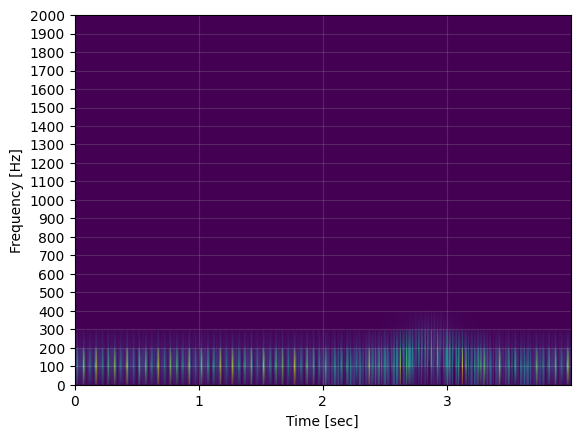

In [3]:
from scipy import signal
f, t, Sxx = signal.spectrogram(samples, fs, window=('tukey', 10), noverlap=0, nperseg=fs//100)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 2_000)
plt.yticks(np.linspace(0, 2_000, 21))
plt.xticks(np.arange(0, duration))
plt.grid(alpha=.2)
#plt.ylim(0, 500)
plt.show()

In [4]:
different_exhausts = [
    car_exhaust(
        frequencies = parameters[0],
        general_modulation=parameters[1],
        revving_zone=parameters[2],
        volume=.4,
        duration=duration
    )[1]
    for parameters in [
        [np.array([20, 100, 60, 200, 30])*2, 30, [0, 2]],
        [np.array([30, 70, 40, 300, 25])*2, 30, [1, 3]],
        [np.array([40, 90, 50, 100, 45])*2, 40, [2, 4]],
        [np.array([35, 110, 40, 250, 55])*2, 20, [1, 3]],
    ]
]

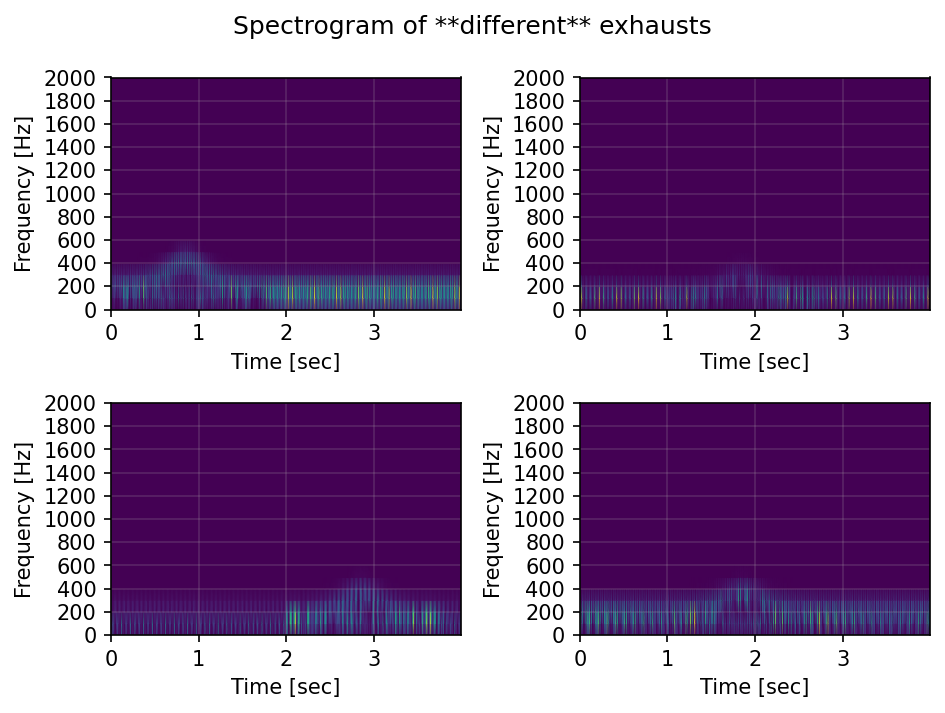

In [5]:
from scipy import signal
fig, axs = plt.subplots(2, 2, dpi=150)
for i, exhaust in enumerate(different_exhausts):
    ax = axs[i//2][i%2]
    f, t, Sxx = signal.spectrogram(exhaust, fs, window=('tukey', 10), noverlap=0, nperseg=fs//100)
    ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_ylim(0, 2_000)
    ax.set_yticks(np.linspace(0, 2_000, 11))
    ax.set_xticks(np.arange(0, duration))
    ax.grid(alpha=.2)
    #plt.ylim(0, 500)

plt.suptitle("Spectrogram of **different** exhausts")
plt.tight_layout() 

    

Text(0.5, 1.0, 'Positions of elements\nthird dimension ignored (for now)')

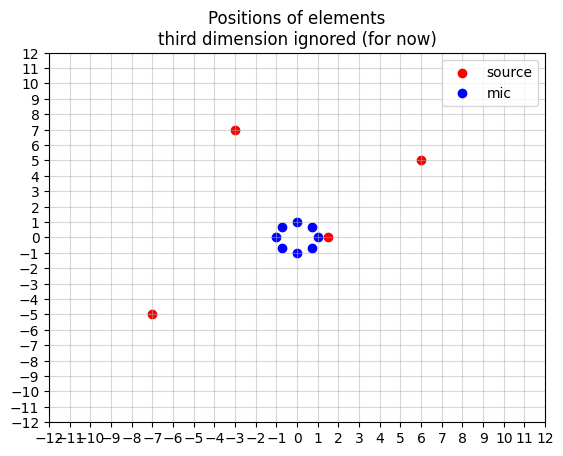

In [6]:
N_mics = 8

source_positions = np.array([
    [6, 5],
    [-3, 7],
    [-7, -5],
    [1.5, 0],
])


angle_rotation = np.pi * 2 / N_mics
rotation_matrix = np.array([
    [np.cos(angle_rotation), -np.sin(angle_rotation)],
    [np.sin(angle_rotation), np.cos(angle_rotation)]
])
mic_positions = []
for i in range(N_mics):
    last_position = mic_positions[-1] if mic_positions else np.array([1, 0])
    mic_positions.append(np.matmul(rotation_matrix, last_position))

mic_positions = np.stack(mic_positions)

plt.scatter(
    source_positions[:, 0],
    source_positions[:, 1],
    label="source",
    color="red",
    marker="o"
)

plt.scatter(
    mic_positions[:, 0],
    mic_positions[:, 1],
    label="mic",
    color="blue",
    marker="o"
)
plt.ylim(-12, 12)
plt.xlim(-12, 12)
plt.xticks(np.linspace(-12, 12, 25))
plt.yticks(np.linspace(-12, 12, 25))
plt.legend()
plt.grid(alpha=.5)
plt.title("Positions of elements\nthird dimension ignored (for now)")

Quiero una matriz donde el elemento ij sea la distancia del microfono i a la fuente j.
Entonces
$$X_{ij} = ||M_i - S_j||$$

La fila $i$ entonces es 

$$ X_i = \left ( ||M_i - S_0||, ... , ||M_i - S_m||\right ) $$



In [7]:
distances = []
for mic_i in range(mic_positions.shape[0]):
    distances.append(np.linalg.norm((source_positions - mic_positions[mic_i, :]), axis=1))
#np.concatenate(distances, axis=1)
distances = np.array(distances)
np.round(distances, 2)
#(mic_positions - source_positions[0, :])

array([[6.81, 7.3 , 9.59, 1.06],
       [7.21, 6.71, 9.22, 1.8 ],
       [7.96, 6.7 , 8.5 , 2.32],
       [8.6 , 7.28, 7.81, 2.5 ],
       [8.81, 8.04, 7.62, 2.32],
       [8.49, 8.54, 8.06, 1.8 ],
       [7.78, 8.55, 8.82, 1.06],
       [7.07, 8.06, 9.43, 0.5 ]])

In [8]:
speed_of_sound = 20
time_window = 3
mic_signals = []

for mic_i in range(len(mic_positions)):
    mic_signal = None
    for source_j in range(len(source_positions)):
        delay = distances[mic_i, source_j]/speed_of_sound
        start = int(fs * delay)
        stop = start + int(fs * time_window)
        attenuation = 1/(np.log(delay+1)) # TODO: CHECK THIS
        delayed_signal = attenuation * different_exhausts[source_j][start:stop]
        print(f"Delay for source {source_j} to microphone {mic_i} is {delay:.2f}")
        if mic_signal is None:
            mic_signal = delayed_signal
        else:
            mic_signal += delayed_signal
    mic_signals.append(mic_signal)

Delay for source 0 to microphone 0 is 0.34
Delay for source 1 to microphone 0 is 0.37
Delay for source 2 to microphone 0 is 0.48
Delay for source 3 to microphone 0 is 0.05
Delay for source 0 to microphone 1 is 0.36
Delay for source 1 to microphone 1 is 0.34
Delay for source 2 to microphone 1 is 0.46
Delay for source 3 to microphone 1 is 0.09
Delay for source 0 to microphone 2 is 0.40
Delay for source 1 to microphone 2 is 0.33
Delay for source 2 to microphone 2 is 0.42
Delay for source 3 to microphone 2 is 0.12
Delay for source 0 to microphone 3 is 0.43
Delay for source 1 to microphone 3 is 0.36
Delay for source 2 to microphone 3 is 0.39
Delay for source 3 to microphone 3 is 0.12
Delay for source 0 to microphone 4 is 0.44
Delay for source 1 to microphone 4 is 0.40
Delay for source 2 to microphone 4 is 0.38
Delay for source 3 to microphone 4 is 0.12
Delay for source 0 to microphone 5 is 0.42
Delay for source 1 to microphone 5 is 0.43
Delay for source 2 to microphone 5 is 0.40
Delay for s

## Implementation of algorithm


The core stages of the proposed method are:
1. The application of a joint-sparsifying transform to the
observations, using the above TF transform.
2. The single-source constant-time analysis zones detection
(Section III-B).
3. The DOA estimation in the single-source zones (Sec-
tion III-C).
4. The generation and smoothing of the histogram of a block
of DOA estimates (Section III-D).
5. The joint estimation of the number of active sources
and the corresponding DOAs with matching pursuit (Sec-
tion III-E).

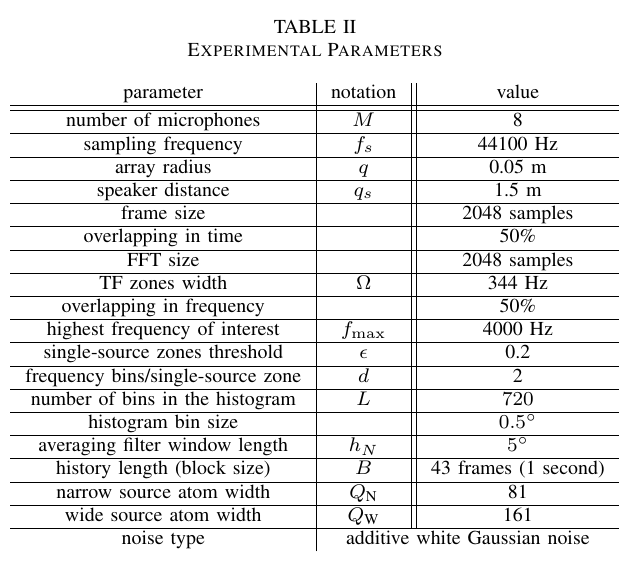

#### Generating overlapping time slices

In [9]:
slice_size = 2048
overlap_size = slice_size // 2
mic_time_slices = []

for mic_i, signal in enumerate(mic_signals):
    mic_time_slices.append(list())
    for j in range(len(signal) // slice_size):
        overlapping_mask = overlap_size * (j>0)
        mic_time_slices[mic_i].append(signal[j*slice_size - overlapping_mask :(j+1)*slice_size - overlapping_mask])

In [10]:
len(mic_time_slices[1]), len(mic_signals[1]), j*slice_size

(64, 132300, 129024)

In [11]:
from scipy.fft import fft, fftfreq

# nint, optional
#Length of the transformed axis of the output. 
#If n is smaller than the length of the input, the input is cropped. 
#If it is larger, the input is padded with zeros. 
#If n is not given, the length of the input along the axis specified by axis is used.
# [Since slice_size = 2048 then the FFT is also 2048]
mic_fft_slices = [[fft(_slice) for _slice in slices] for slices in mic_time_slices]

# Observación sobre las frecuencias:
# At y[n/2] we reach the Nyquist frequency and wrap around to the negative-frequency terms. 
# To rearrange the fft output so that the zero-frequency component is centered, like [-4, -3, -2, -1, 0, 1, 2, 3], use fftshift.


# We then define a “constant-time analysis zone”, (t, Ω), as a
# series of frequency-adjacent TF points (t, ω). A “constant-time
# analysis zone”, (t, Ω) is thus referred to a specific time frame t
# and is comprised by Ω adjacent frequency components.

freq_bins = fftfreq(slice_size, 1/fs)
np.round(freq_bins[:20], 2)

array([  0.  ,  21.53,  43.07,  64.6 ,  86.13, 107.67, 129.2 , 150.73,
       172.27, 193.8 , 215.33, 236.87, 258.4 , 279.93, 301.46, 323.  ,
       344.53, 366.06, 387.6 , 409.13])

#### Single source analysis zones detection

In [12]:
adjacent_zone = 2
print(f"Using freq bins of {freq_bins[adjacent_zone+1] - freq_bins[1]:.2f}Hz")

def correlation(mic1, mic2, timestep, f_from, f_to):
    return np.linalg.norm(
        mic_fft_slices[mic1][timestep][f_from:f_to]
        * mic_fft_slices[mic2][timestep][f_from:f_to],
        ord=1
    )

def cross_correlation(mic1, mic2, timestep, f_from, f_to):
    # Cross correlation
    corr = correlation(mic1, mic2, timestep, f_from, f_to)

    # Correlation coefficient
    correlation_coefficient = corr / np.sqrt(
        correlation(mic1, mic1, timestep=timestep, f_from=f_from, f_to=f_to)
        * correlation(mic2, mic2, timestep=timestep, f_from=f_from, f_to=f_to)
    )
    return correlation_coefficient

Using freq bins of 43.07Hz


In [13]:
single_source_threshold = 0.8
cross_correlation(0, 1, 4, 1, 1+adjacent_zone) >= single_source_threshold

True

In [14]:
def is_single_source_zone(zone_index, timestep):
    avg = 0
    omega_index = adjacent_zone * zone_index
    for i in range(1, N_mics):
        next_mic = (i+1) % N_mics
        avg += 1/N_mics * cross_correlation(i, next_mic, timestep, omega_index, omega_index+adjacent_zone)
    return avg >= single_source_threshold


In [15]:
distance_to_next_mic = np.linalg.norm(mic_positions[0, :] - mic_positions[1, :])

In [16]:

A = np.pi/2 + angle_rotation/2
A_prime = A + np.pi/2 

def cics(phi, omega_index, t):
    value = 0 
    omega = freq_bins[omega_index]
    for i in range(N_mics):
        # +1 because we use zero-index; eqn uses -1
        phase_rotation_factor = np.exp(- 1j * omega * distance_to_next_mic/speed_of_sound * (np.sin(A_prime - phi) - np.sin(A_prime - phi + (i+1-1) * angle_rotation)))
        # What happens in the last microphone?? I'm guessing wrap-around
        cross_power = mic_fft_slices[i][t][omega_index] * np.conj(mic_fft_slices[((i+1) % N_mics)][t][omega_index])

        phase_cross_spectrum = cross_power / np.conj(cross_power)
        value += phase_cross_spectrum * phase_rotation_factor
    return np.abs(value)



In [17]:
import scipy 
t = 10

for omega_index in range(100):
    scipy.optimize.minimize_scalar(cics, method="bounded", bounds=(0, 2*np.pi), args=(3, t))

In [18]:
def d_highest_peaks(freq_from, freq_to, timestep, d):
    magnitudes = {}
    for freq in range(freq_from, freq_to):
        val = 0
        for i in range(N_mics):
            next_mic = (i+1) % N_mics
            val += np.abs(mic_fft_slices[i][timestep][freq] * np.conj(mic_fft_slices[next_mic][timestep][freq]))
        magnitudes[freq] = val
    return sorted(magnitudes, key=magnitudes.__getitem__)[-2:]

In [19]:
len(mic_fft_slices[1])

64

In [20]:
D=4
# Choosing the important frequencies
# The paper selects w_i_max for each microphone pair for each single source zone.
doa_zone_estimations = []
t_min, t_max = 10, 20
for t in range(t_min, t_max):
    for zone in range(50):
        if not is_single_source_zone(zone, t):
            continue
        top_frequency_indices = d_highest_peaks(zone*adjacent_zone, (zone+1)*adjacent_zone, timestep=t, d=D)
        for frequency_index in top_frequency_indices:
            # for single source zone, detect DoA
            result = scipy.optimize.minimize_scalar(cics, method="bounded", bounds=(0, 2*np.pi), args=(frequency_index, t))
            doa_zone_estimations.append(result.x)
        

Text(0, 0.5, '# Estimation')

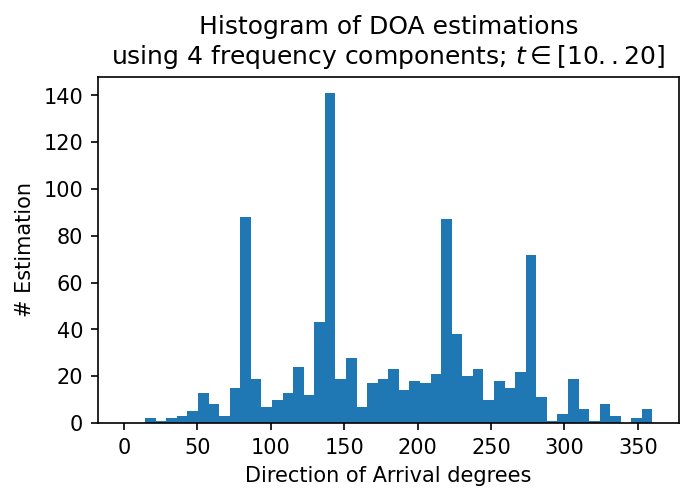

In [66]:
L = 50 # histogram length
plt.figure(dpi=150, figsize=(5, 3))
plt.title(f"Histogram of DOA estimations\nusing {D} frequency components; $t\in [{t_min}..{t_max}]$")
bins, x, _ = plt.hist(np.array(doa_zone_estimations)*360/(2*np.pi), bins=np.linspace(0, 360, L+1))
#plt.xticks()
plt.xlabel("Direction of Arrival degrees")
plt.ylabel("# Estimation")

In [68]:
doa_hist = dict(zip(x, bins))

best_doa_estimation = sorted(doa_hist, key=doa_hist.__getitem__)[-4:]

Text(0.5, 1.0, 'DoA estimation')

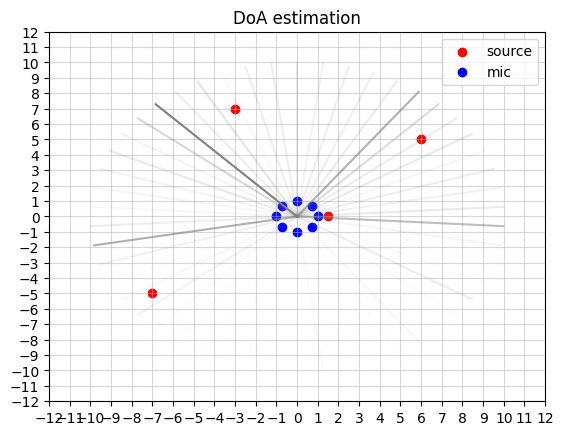

In [69]:
plt.scatter(
    source_positions[:, 0],
    source_positions[:, 1],
    label="source",
    color="red",
    marker="o"
)

plt.scatter(
    mic_positions[:, 0],
    mic_positions[:, 1],
    label="mic",
    color="blue",
    marker="o"
)
max_value = bins.max()
# for estimation in best_doa_estimation:
#     plt.plot(
#         [0, 10*np.sin(estimation/360 * 2*np.pi)],
#         [0, 10*np.cos(estimation/360 * 2*np.pi)],
#     )
for value, freq in doa_hist.items():
    plt.plot(
        [0, 10*np.sin(value/360 * 2*np.pi - np.pi)],
        [0, 10*np.cos(value/360 * 2*np.pi - np.pi)],
        alpha=freq/max_value,
        color="gray"
    )
plt.ylim(-12, 12)
plt.xlim(-12, 12)
plt.xticks(np.linspace(-12, 12, 25))
plt.yticks(np.linspace(-12, 12, 25))
plt.legend()
plt.grid(alpha=.5)
plt.title("DoA estimation")

#### Histogram smoothing

$$y(v) = \sum_{i=1}^N w \left ( \frac{v\cdot 360 /L - \xi_i}{h_N}\right )$$

* $L$ is the number of bins 
* $\xi_i$ = ith estimate out of N estimates in block
* $w$ is the rectangular window ($w: \mathbb{R} \rightarrow \mathbb{R}$)

In [28]:
v = np.arange(x.shape[0])
(v * 360 / (v.max()) - )

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

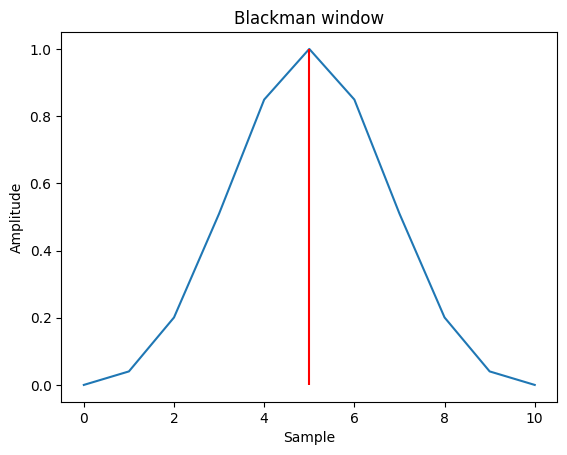

In [70]:
from scipy import signal
Q0 = 5
Q = 2*Q0+1
window = signal.windows.blackman(Q)
plt.plot(window)
plt.title("Blackman window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.vlines(Q0, 0, 1, color="red")


In [71]:
u = np.zeros(L)
u[:Q] = window 
c = np.roll(u, -Q0)


In [74]:
C = np.array([np.roll(c, k) for k in range(L)])
C.shape

(50, 50)

In [73]:
bins.shape

(50,)

En el paper no está escrita la condición de corte (se usan unos parámetros que no están establecidos) así que voy a utilizar que la energía tiene que ser a l omayor.


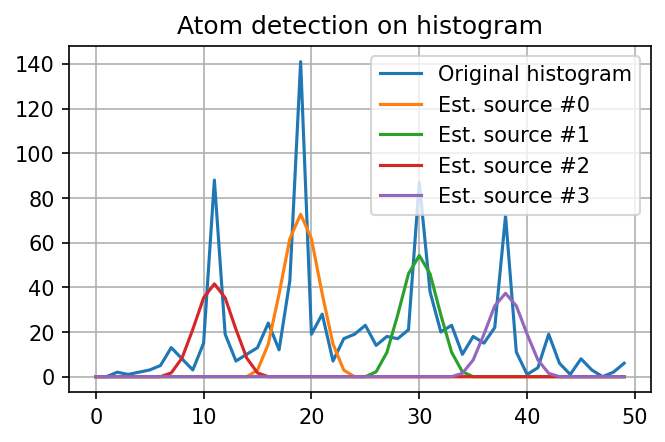

In [130]:
max_sources = 10
plt.figure(dpi=150, facecolor="white", figsize=(5, 3))
plt.plot(np.arange(L), bins, label="Original histogram")

current_histogram = bins
atoms = []
atom_energies = []
window_energy = np.dot(c, c)
energy_threshold = bins.mean()
for j in range(max_sources):
    corr_window = C.dot(current_histogram)
    position = np.argmax(corr_window)
    atom_energy = corr_window.max() / window_energy
    if atom_energy < energy_threshold:
        break
    atom_contribution = C[position, :] * atom_energy
    current_histogram = current_histogram - atom_contribution
    plt.plot(np.arange(L), atom_contribution, label=f"Est. source #{j}")
    atoms.append(position)
    atom_energies.append(atom_energy)

#for j in range(C.shape[1]):
#    plt.plot(np.arange(L), 140*C[j, :], alpha=.1 if j != np.argmax(bins) else 1, color="red")
plt.title("Atom detection on histogram")
plt.grid()
plt.legend()

#plt

Cómo funciona esto en tiempo real:

> In each time frame we form a smoothed histogram from
the estimates of the current frame and the B − 1 previous
frames. Once we have the histogram in the nth time frame
(the length-L vector, y n), our goal is to count the number of
active sources and to estimate their DOAs. In our previous
work, [31], [32] we performed these tasks separately, but here
we combine them into a single process.

Pendiente para mi caso que no está en el paper:

- Luego con los picos es necesario volver a los bloques que votaron ese pico y calcular los decibeles.